In [28]:
%cd drive/MyDrive/algea
!pip install geopandas shapely odc-stac nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 53.5 MB/s eta 0:00:00


In [4]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [29]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [22]:
DATA_DIR = os.path.join(Path.cwd().resolve(), "data")
os.makedirs(DATA_DIR)

In [24]:
metadata = pd.read_csv(DATA_DIR + '/metadata.csv')
metadata.head(3)

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train


In [26]:
metadata['split'].value_counts()

train    17060
test      6510
Name: split, dtype: int64

# Location

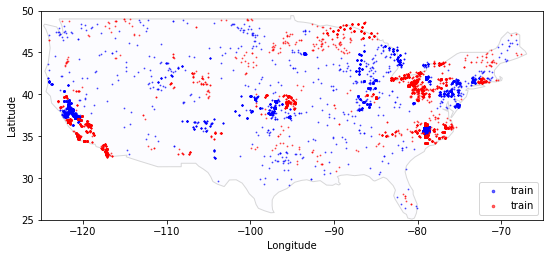

In [33]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(9, 4))

base = world[world['name'] == 'United States of America'].plot(edgecolor='gray', color='ghostwhite', figsize=(9, 4), alpha=0.3, ax=ax)

train_meta = metadata[metadata['split'] == 'train']
geometry = [Point(xy) for xy in zip(train_meta['longitude'], train_meta['latitude'])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker='.', markersize=3, color='blue', label='train', alpha=0.6)

test_meta = metadata[metadata['split'] == 'test']
geometry = [Point(xy) for xy in zip(test_meta['longitude'], test_meta['latitude'])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker='.', markersize=3, color='red', label='train', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

# Date

In [34]:
metadata['date'] = pd.to_datetime(metadata['date'])
metadata.groupby('split').agg(min_date=('date', min), max_date=('date', max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


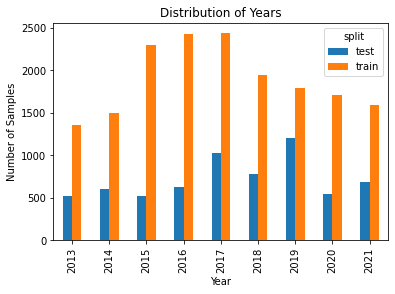

In [38]:
pd.crosstab(metadata['date'].dt.year, metadata['split']).plot(kind='bar')
plt.ylabel("Number of Samples")
plt.xlabel('Year')
plt.title("Distribution of Years")
plt.show()

In [39]:
metadata['season'] = (
    metadata['date'].dt.month.replace([12, 1, 2], 'winter')
    .replace([3, 4, 5], 'spring')
    .replace([6, 7, 8], 'summer')
    .replace([9, 10, 11], 'fall')
)
metadata['season'].value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

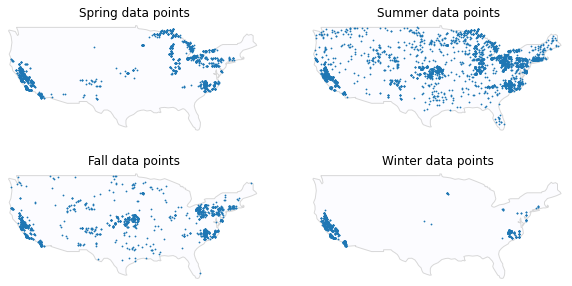

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata['season'].unique(), axes.ravel()):
    base = world[world['name'] == 'United States of America'].plot(
        edgecolor='gray', color='ghostwhite', alpha=0.3, ax=ax)
    
    sub = metadata[metadata['season'] == season]
    geometry = [Point(xy) for xy in zip(sub['longitude'], sub['latitude'])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker='.', markersize=2.5)
    ax.set_ylim([25, 50])
    ax.set_xlim([-125, -66])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis('off')

# Train Labels

In [41]:
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv')
train_labels.head(3)

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0


In [42]:
train_labels.shape

(17060, 4)

Text(0.5, 1.0, 'Train labels severity level counts')

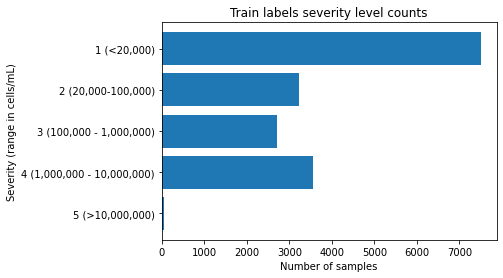

In [43]:
train_merged = train_labels.merge(metadata, how='left', left_on='uid', right_on='uid', validate='1:1')

severity_counts = (
    train_labels.replace({
        'severity': {
            1: '1 (<20,000)',
            2: '2 (20,000-100,000)',
            3: '3 (100,000 - 1,000,000)',
            4: '4 (1,000,000 - 10,000,000)',
            5: '5 (>10,000,000)'}
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [44]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

In [45]:
(train_labels.density == 0).sum()

91

# Submission

In [46]:
submission = pd.read_csv(DATA_DIR + '/submission_format.csv', index_col=0)
submission.head(3)

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1


In [47]:
submission.shape

(6510, 2)